In [1]:
DATA_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/data2/' # "./../"
DATA_VERSION = 'oct22'
RESULTS_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/results/'
SHAM = True

########################################################################################
sham_str = '_wSham' if SHAM else ''

In [2]:
import os 
import numpy as np
import itertools
import scipy as sci
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

import scanpy as sc
import anndata as ann

from scipy.sparse import csr_matrix, issparse
import matplotlib
from matplotlib import rcParams
from matplotlib import colors


sc.settings.verbosity = 3
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.6.1
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              1.0.9
certifi             2020.12.05
cffi                1.14.4
chardet             4.0.0
cloudpickle         1.6.0
constants           NA
cycler              0.10.0
cython_runtime      NA
dask                2020.12.0
dateutil            2.8.1
decorator           4.4.2
future_fstrings     NA
get_version         2.1
google              NA
h5py                2.10.0
highs_wrapper       NA
idna                2.10
igraph              0.8.3
ipykernel           5.4.3
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.2
joblib              1.0.0
json5               NA
jsonschema          3.2.0
jupyter_server      1.2.1
jupyterlab_server   2.1.2
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg

# Dot plot of curated markers
for coarse (level1) and fine (level2) cell type annotations

In [3]:
adata = sc.read(DATA_DIR+f'cellxgene_{DATA_VERSION}{sham_str}_umaps.h5ad')

In [4]:
plt.rcParams['figure.dpi'] = 150
SMALL_SIZE = 17
MEDIUM_SIZE = 19
BIGGER_SIZE = 21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
adata.obs["level1"].cat.categories

Index(['progenitors', 'neutrophil', 'monocyte', 'B cell', 'T cell', 'NK cell',
       'NK-T cell', 'dendritic cell', 'macrophage', 'microglia',
       'erythroid precursor', 'erythroid cell', 'basophil', 'structural cell',
       'brain cell', 'megakaryocyte', 'innate lymphoid cell'],
      dtype='object')

In [6]:
#rename:
#    level1:
#        basophil --> basophil (pooled)
#    level2:
#        macrophage --> macrophage (other)

adata.obs["level1"] = adata.obs["level1"].cat.rename_categories({'basophil': 'basophil (pooled)'})
adata.obs["level1"] = adata.obs["level1"].cat.rename_categories({'erythroid cell': 'erythroid'})
adata.obs.loc[adata.obs["level1"] == "erythroid precursor", "level1"] = "erythroid"
adata.obs["level2"] = adata.obs["level2"].cat.rename_categories({'macrophage': 'macrophage (other)'})

adata.obs.loc[adata.obs["level2"]=='monocyte-DC progenitor (MDP)', "level2"] = 'common DC progenitor (CDP)'

adata.obs["level2"] = adata.obs["level2"].cat.remove_unused_categories()

# Reorder level2 categories

reorder_level2 = [
    'hematopoietic stem cell', 'common myeloid progenitor',
    'granulocyte-monocyte progenitor', 'neutrophil-primed GMP',
    'monocyte-primed GMP', #'erythroid progenitor',
    #'monocyte-DC progenitor (MDP)', 
    'erythroid progenitor', 'common DC progenitor (CDP)',  #
    
    'pro neutrophil', 'pre neutrophil', 'immature neutrophil', 'mature neutrophil', 
    
    'basophil progenitor', 'basophil', 
    
    'monocyte progenitor', 'classical monocyte', 'non-classical monocyte', 
    
    'pro B cell', 'pre B cell', 'immature B cell', 'mature B cell', 'plasma cell',     
    
    'erythroid cell', 'erythroblast', 'erythrocyte',    
    
    'plasmacytoid DC', 'conventional DC1', 'conventional DC2', #'monocyte-derived DC', 'B cell-DC hybrid', 'neutrophil-DC hybrid',     
    
    'Cd8 T cell', 'Cd4 T cell', 'gdT cell', 'NK-T cell', 'NK cell', 
    
    'perivascular macrophage', 'monocyte-derived macrophage', 'microglia', 'macrophage (other)', 'antigen-presenting macrophage', 
    
    'megakaryocyte', 
    
    'innate lymphoid cell',
    
    'neuron', 'astrocyte', 'oligodendrocyte',
    
    'fibroblast', 'dural fibroblast', 'endothelial cell', 'adipose-derived stromal cell',
    'brain-Chroid Plexus endothelial cell', 'meningeal-Choroid Plexus cell', 'Omp+ cell', 'Gnb3+ cell', 
]

adata.obs["level2"] = adata.obs["level2"].cat.reorder_categories(reorder_level2)

adata.obs["level1"] = adata.obs["level1"].cat.remove_unused_categories()
adata.obs["level2"] = adata.obs["level2"].cat.remove_unused_categories()

In [7]:
cts_level1 = {
    #progenitors    
    'progenitors'          :'#ff9896',
    #neutrophils    
    'neutrophil'           :'#279e68',
    #monocytes    
    'monocyte'             :'#98df8a', 
    #B cells    
    'B cell'               :'#1f77b4',
    #NK and T cells    
    'T cell'               :'#FFBB78',
    'NK cell'              :'#e8d611',
    'NK-T cell'            :'#084a21',    
    #dendritic cells    
    'dendritic cell'       :'#17becf',    
    #macrophages
    'macrophage'           :'#9E72FF',
    'microglia'            :'#3d0a61',    
    #erythroid cells    
    'erythroid precursor'  :'#B67A6E',
    'erythroid'            :'#8c564b',#'erythroid cell'       :'#8c564b',
    #basophil
    'basophil (pooled)'    :'#9127E3',#'basophil'             :'#9127E3',
    #structural cells
    'structural cell'      :'#e86711',
    #brain cells
    'brain cell'           :'#FFE4B2',
    #others          
    'megakaryocyte'        :'#FFD8FF',
    'innate lymphoid cell' :'#aec7e8',
}

cts_level2 = {
    #progenitors
    'hematopoietic stem cell'              : '#FFCBC9',
    'common myeloid progenitor'            : '#E67F7D',
    'granulocyte-monocyte progenitor'      : '#B34C4A',
    'neutrophil-primed GMP'                : '#bdffff',#'#D9FFFF',
    'monocyte-primed GMP'                  : '#bbffa8',#'#CBFFBD',
    'erythroid progenitor'                 : '#ffe0cc',#'#FFEFE4',
    ###'macrophage-DC progenitor (MDP)'       : '#6dc74c',
    'common DC progenitor (CDP)'           : '#CF2917', #'#81c47b',
    #neutrophils
    'pro neutrophil'                       : '#85ffde',#'#A6FFE7',
    'pre neutrophil'                       : '#74EBB5',
    'immature neutrophil'                  : '#279e68',
    'mature neutrophil'                    : '#006B35',
    #monocytes
    'monocyte progenitor'                  : '#98DF8A',        
    'classical monocyte'                   : '#D08ADE',
    'non-classical monocyte'               : '#8AC2DE',
    #B cells
    'pro B cell'                           : '#B8FFFF',
    'pre B cell'                           : '#85DDFF',
    'immature B cell'                      : '#52AAE7',
    'mature B cell'                        : '#1f77b4',
    'plasma cell'                          : '#002B68',
    #NK and T cells
    'Cd8 T cell'                           : '#B36F2C',
    'Cd4 T cell'                           : '#FFBB78',
    'gdT cell'                             : '#662200',
    'NK-T cell'                            : '#279e68',
    'NK cell'                              : '#e8d611',
    #dendritic cells
    'plasmacytoid DC'                      : '#17becf',
    'conventional DC1'                     : '#60CF17',
    'conventional DC2'                     : '#8517CF',
    'monocyte-derived DC'                  : '#CF2917',
    ###'B cell-DC hybrid'                     : '#005869',
    ###'neutrophil-DC hybrid'                 : '#0044FF',
    #macrophages
    'perivascular macrophage'              : '#B80022',
    'monocyte-derived macrophage'          : '#0077B8',
    'microglia'                            : '#3d0a61',
    'macrophage (other)'                   : '#9E72FF',#'macrophage'                           : '#9E72FF',
    'antigen-presenting macrophage'        : '#00B896',    
    #erythroid cells
    'erythroid cell'                       : '#F2BCB1',
    'erythroblast'                         : '#BF897E',    
    'erythrocyte'                          : '#8c564b',
    #basophil
    'basophil progenitor'                  : '#DE74FF',    
    'basophil'                             : '#9127E3',
    #structural cells
    'fibroblast'                           : '#D6E810',
    'dural fibroblast'                     : '#2210E8',
    'endothelial cell'                     : '#10E88E',
    'adipose-derived stromal cell'         : '#1092E8',    
    'brain-Chroid Plexus endothelial cell' : '#40bcf2',
    'meningeal-Choroid Plexus cell'        : '#e8116b',
    'Omp+ cell'                            : '#D210E8',
    'Gnb3+ cell'                           : '#e86711',    
    #brain cells
    'neuron'                               : '#B3CDFF',     
    'astrocyte'                            : '#FFB3F4',
    'oligodendrocyte'                      : '#4D9958',
    #others                                                                                               
    'megakaryocyte'                        : '#1EB279',
    'innate lymphoid cell'                 : '#a055ad',    
}


#adata.obs['level1'].cat.reorder_categories([celltype for celltype in cts_level1],inplace=True)
adata.uns['level1_colors'] = [cts_level1[ct] for ct in adata.obs["level1"].cat.categories]
#adata.obs['level2'].cat.reorder_categories([celltype for celltype in cts_level2],inplace=True)
adata.uns['level2_colors'] = [cts_level2[ct] for ct in adata.obs["level2"].cat.categories]

In [8]:
#                                              [color_on, level, [markers], number_of_genes_to_plot]
plot_info = {
    'progenitors'                              :[True , "level1", ["Stmn1", "Tubb5", "Lmnb1", "Hmgb2", "Nucks1", "Dek"], 3], ### Stmn1 , Hmgb2, Tubb5, Lmnb1, "Nucks1", "Dek"
        'hematopoietic stem cell'              :[False, "level2", ["Cd34", "Adgrl4", "Hlf", "Sox4"], 2], ### "Adgrl4", Hlf
        'common myeloid progenitor'            :[False, "level2", ["Sox4", "Itga2b", "Gata2", "Adgrg1"], 3], ### "Cdk6"
        'granulocyte-monocyte progenitor'      :[False, "level2", ["Ctsg", "Mpo", "Prtn3"], 2], ### Mif
        'neutrophil-primed GMP'                :[False, "level2", ["Prtn3", "Fcnb", "Camp","Anxa1","Lcn2"], 2],  ### Fcnb, Anxa1, Lcn2, "Camp"
        'monocyte-primed GMP'                  :[False, "level2", ["F13a1","Klf4","Prc1", "Nusap1","Top2a"], 3], ### F13a1, Klf4
        'erythroid progenitor'                 :[False, "level2", ["Cpox", "Hmbs", "Slc4a1", "Tuba1b"], 2],  ### Hmbs, Cpox    
        #'monocyte-DC progenitor (MDP)'         :[False, "level2", ["Flt3", "Bst2", "Bcl11a", "Runx2"], 2],  ### "Top2a" 
        'common DC progenitor (CDP)'           :[False, "level2", ["Flt3","Siglech"]],  # , "Runx2", "Bcl11a", "Bst2", "Bmya", "Mef2c" 
    'neutrophil'                               :[True , "level1", ["S100a9","S100a8"]],
        'pro neutrophil'                       :[False, "level2", ["Mki67", "Top2a", "Cebpe"]],  ### "Cebpe"
        'pre neutrophil'                       :[False, "level2", ["Ptma","Rpl3"]],
        'immature neutrophil'                  :[False, "level2", ["Ngp","Ltf"]],
        'mature neutrophil'                    :[False, "level2", ["Ccl6", "Cxcr2"]],
    'basophil (pooled)'                        :[True , "level1", ["Alox15", "Ms4a2", "Cyp11a1", "Gata2"], 2], # "Rps11" not so great ### Ms4a2, "Cyp11a1"
        'basophil progenitor'                  :[False, "level2", ["Prss34", "Mcpt8", "H2afz"], 2],
        'basophil'                             :[False, "level2", [None,None], 0], # "Cd7", "Hpc" ### already clear with basophil pooled + basophil progenitor
    'monocyte'                                 :[True , "level1", ["Ccr2","Fn1", "Hopx"]], # "Psap"? ### "Fn1", "Hopx"
        'monocyte progenitor'                  :[False, "level2", ["Stmn1", "Mki67", "Ptma", "H2afz"],2], # are there better ones?
        'classical monocyte'                   :[False, "level2", ["Vcan", "Ms4a8a", "Chil3", "Cd14"],2],  ### "Vcan" "Ms4a8a"
        'non-classical monocyte'               :[False, "level2", ["Cx3cr1", "Hpgd", "Csf1r"], 2], # 
    'B cell'                                   :[True , "level1", ["Cd79a", "Ighm"]], ### Ebf1, Cd177
        'pro B cell'                           :[False, "level2", ["Vpreb1", "Vpreb3"]], #"Vpreb3" 
        'pre B cell'                           :[False, "level2", ["Bcl7a", "Dnajc7"]], #"Vpreb3",  ### Bcl7a
        'immature B cell'                      :[False, "level2", ["Iglc1", "Ms4a1"]],
        'mature B cell'                        :[False, "level2", ["H2-Aa", "H2-Eb1"]], ### "Ighd"
        'plasma cell'                          :[False, "level2", ["Jchain", "Txndc5", "Xbp1", "Iglc1"], 2], ### "Xbp1", "Iglc1"
    #'erythroid precursor'                      :[True , "level1", ["Hmbs","Dennd4a"]], #Check ("Car2") and ### "Hmbs" "Dennd4a" 
    #    'erythroid cell'                       :[False, "level2", []],# 
    #'erythroid cell'                           :[True , "level1", ["Hba-a1", "Hbb-bs"]], ### Mkrn1
    #    'erythroblast'                         :[False, "level2", ["Prdx2", "Car2"]],
    #    'erythrocyte'                          :[False, "level2", [None,None]], # I think not really needed "Hba-a1", "Hbb-bs" is fine    
    'erythroid'                                :[True , "level1", ["Hba-a1", "Hbb-bs"]], ### Mkrn1
        'erythroid cell'                       :[True , "level2", ["Hmbs","Dennd4a"]], #Check ("Car2") and ### "Hmbs" "Dennd4a" 
        'erythroblast'                         :[False, "level2", ["Prdx2", "Car2"]],
        'erythrocyte'                          :[False, "level2", [None,None]], # I think not really needed "Hba-a1", "Hbb-bs" is fine        
    'dendritic cell'                           :[True , "level1", ["Flt3", "Irf8"]], #"Psap" ? ### "Irf8", "Flt3"
        'plasmacytoid DC'                      :[False, "level2", ["Siglech","Ctsl"]], #, Irf8 --> not specific enough!
        'conventional DC1'                     :[False, "level2", ["Ifi205", "Clec9a", "Id2", "Xcr1", "Cadm1", "Naaa"], 2], # maybe sth more specific than Id2? "Itgax" doesn't work well ### "Ifi205"
        'conventional DC2'                     :[False, "level2", ["Tmem176b", "Cd209a", "Ifitm3", "Ciita", "Sirpa", "H2-DMb2", "Itgam"], 2], # "Itgam" --> are there better ones? ### Ciita, Tmem176b
        #'monocyte-derived DC'                  :[False, "level2", ["Saa3",None]], # "Chil3", "Id2" --> weak. ### "Saa3"
        #'B cell-DC hybrid'                     :[False, "level2", ["Ighm", "Ighd"]], # Maybe there's better ones? Just B markers needed here ### "Ighd"
        #'neutrophil-DC hybrid'                 :[False, "level2", ["S100a9", "Retnlg", "Mmp8", "Csf3r"]],  ### "Mmp8", "Csf3r"    
    'T cell'                                   :[True , "level1", ["Cd3d","Trbc2","Cd3g"]], ### Cd3g, Cd3d, Trbc2, Ms4a4b, Gimap3
        'Cd8 T cell'                           :[False, "level2", ["Cd8a", "Cd8b1", "Ccr7"]], ### "Ccr7"
        'Cd4 T cell'                           :[False, "level2", ["Cd4", None]], #Tspan32, 
        'gdT cell'                             :[False, "level2", ["S100a4", "Maf"]], # 
    'NK-T cell'                                :[True , "level1", ["Il2rb","Gimap4"]], ### Il2rb, Gimap4
    'NK cell'                                  :[True , "level1", ["Ccl5", "Gzma", "Fcer1g"]], ### Gzma, Ms4a4b
    'macrophage'                               :[True , "level1", ["C1qb", "Apoe", "Trem2", "C1qa"], 3], ### C1qa, Trem2
        'perivascular macrophage'              :[False, "level2", ["Ccl8", "Cd163", "C1qc"], 2], ### C1qc
        'monocyte-derived macrophage'          :[False, "level2", ["S100a6","Ms4a6d", "Ms4a8a", "Mafb"], 2], #"H3f3a" 
        'microglia'                            :[False, "level2", ["Hexb", "P2ry12", "Tmem119"], 2], # Only literature genes for microglias!
        'macrophage (other)'                   :[False, "level2", ["Spp1", "Fabp5"]], # "Ctsd" -> more specific one? ### "Fabp5"
        'antigen-presenting macrophage'        :[False, "level2", ["Cd74", "H2-Eb1"]], # "Ctsb" 
    'megakaryocyte'                            :[True , "level1", ["Gng11", "Pf4", "Alox12"]],
    'innate lymphoid cell'                     :[True , "level1", ["Gata3", "Il7r", "Lmo4", "Rnf128"]], ###Gata3, Rnf128    
    'brain cell'                               :[True , "level1", ["Mt1", "Ckb", "Mt3", "Camk2n1", "Gpm6b", "Scd2"],3], # "Ckb" , is there a better one? ### "Ckb" "Mt3" "Camk2n1" "Gpm6b" "Scd2" (brain cells)
        'neuron'                               :[False, "level2", ["Snap25", "Map2", "Camk2a"], 2], # "Rpl38" is there a better one? ### "Camk2a"    
        'astrocyte'                            :[False, "level2", ["Aldoc", "Slc1a2"]], # "F3", "Ndrg2"
        'oligodendrocyte'                      :[False, "level2", ["Gatm", "Olig1", "Pllp"],2], ### Pllp    
    'structural cell'                          :[True , "level1", [None,None]], #"Col1a2" 
        'fibroblast'                           :[False, "level2", ["Cxcl12","Bgn","Tmem176b","Gpx3"], 2], # ,"Col12a1" Maybe exchange "Mgp" and "Col12a1" with dural fibros ### Bgn, Tmem176b, Gpx3
        'dural fibroblast'                     :[False, "level2", ["Mgp", "Fxyd5", "Col1a1"]], # "Apoe" not so great ### "Col1a1"
        'endothelial cell'                     :[False, "level2", ['Pecam1', 'Cldn5', 'Egfl7', 'Ptprb'], 2], # "Ly6a" is there rly no better? Also not so sure about Apoe ### "Vtn"
        'adipose-derived stromal cell'         :[False, "level2", ["Ptgds", "Apod"]], ### "Vtn"
        'brain-Chroid Plexus endothelial cell' :[False, "level2", ["Ins2", "Ins1", "Iapp"],2], ### "Iapp"
        'meningeal-Choroid Plexus cell'        :[False, "level2", ["Enpp2", "Ttr"]], ### "Rbp1"
        'Omp+ cell'                            :[False, "level2", ["Omp", "Gng13", "S100a5"],2], # !! Add Omp!?
        'Gnb3+ cell'                           :[False, "level2", ["Gnb3", "Pde6g", "Tma7", "Chgb", "Cplx3"],2], # !! Add Gnb3 !? ### "Chgb", Cplx3
}




In [9]:

sub_states_boxes = { # key: a colored cell type from plot_info, values: cell types in adata.obs["level2"]
    'progenitors':[
        'hematopoietic stem cell','common myeloid progenitor','granulocyte-monocyte progenitor','neutrophil-primed GMP',
        'monocyte-primed GMP','erythroid progenitor', #'monocyte-DC progenitor (MDP)', 
        'common DC progenitor (CDP)',
        'pro neutrophil', 'monocyte progenitor', 'pro B cell', 'basophil progenitor', 
    ],
    'neutrophil':['pro neutrophil', 'pre neutrophil', 'immature neutrophil', 'mature neutrophil','neutrophil-primed GMP'],
    'monocyte':['monocyte progenitor', 'classical monocyte', 'non-classical monocyte', 'monocyte-primed GMP',],
    'B cell':['pro B cell', 'pre B cell', 'immature B cell', 'mature B cell', 'plasma cell'],
    'T cell':['Cd8 T cell', 'Cd4 T cell', 'gdT cell', 'NK-T cell'],
    'NK-T cell':[],
    'NK cell':[],
    'dendritic cell':['plasmacytoid DC', 'conventional DC1', 'conventional DC2', 'common DC progenitor (CDP)',],#, 'monocyte-derived DC', 'B cell-DC hybrid', 'neutrophil-DC hybrid'],
    'macrophage':['perivascular macrophage', 'monocyte-derived macrophage', 'microglia', 'macrophage (other)', 'antigen-presenting macrophage'],
    #'erythroid precursor':['erythroid cell'],
    #'erythroid cell':['erythroid progenitor', 'erythroblast', 'erythrocyte'],
    'erythroid':['erythroid progenitor', 'erythroid cell', 'erythroblast', 'erythrocyte'],
    'basophil (pooled)':['basophil progenitor', 'basophil'],
    'structural cell':[
        'fibroblast', 'dural fibroblast', 'endothelial cell', 'adipose-derived stromal cell', 'brain-Chroid Plexus endothelial cell', 
        'meningeal-Choroid Plexus cell', 'Omp+ cell', 'Gnb3+ cell'],
    'brain cell':['neuron', 'astrocyte', 'oligodendrocyte'],
    'megakaryocyte':[],
    'innate lymphoid cell':[], 
}


for key, values in plot_info.items():
    plot_info[key][2] = [v for v in values[2] if v != None]
    
genes = {key:values[2] for key, values in plot_info.items()}    
delete_keys = []
for key in genes:
    if len(plot_info[key]) > 3:
        genes[key] = [g for i,g in enumerate(genes[key]) if i < plot_info[key][3]]
    if len(genes[key]) == 0:
        delete_keys.append(key)
for key in delete_keys:
    del genes[key]


## Plot

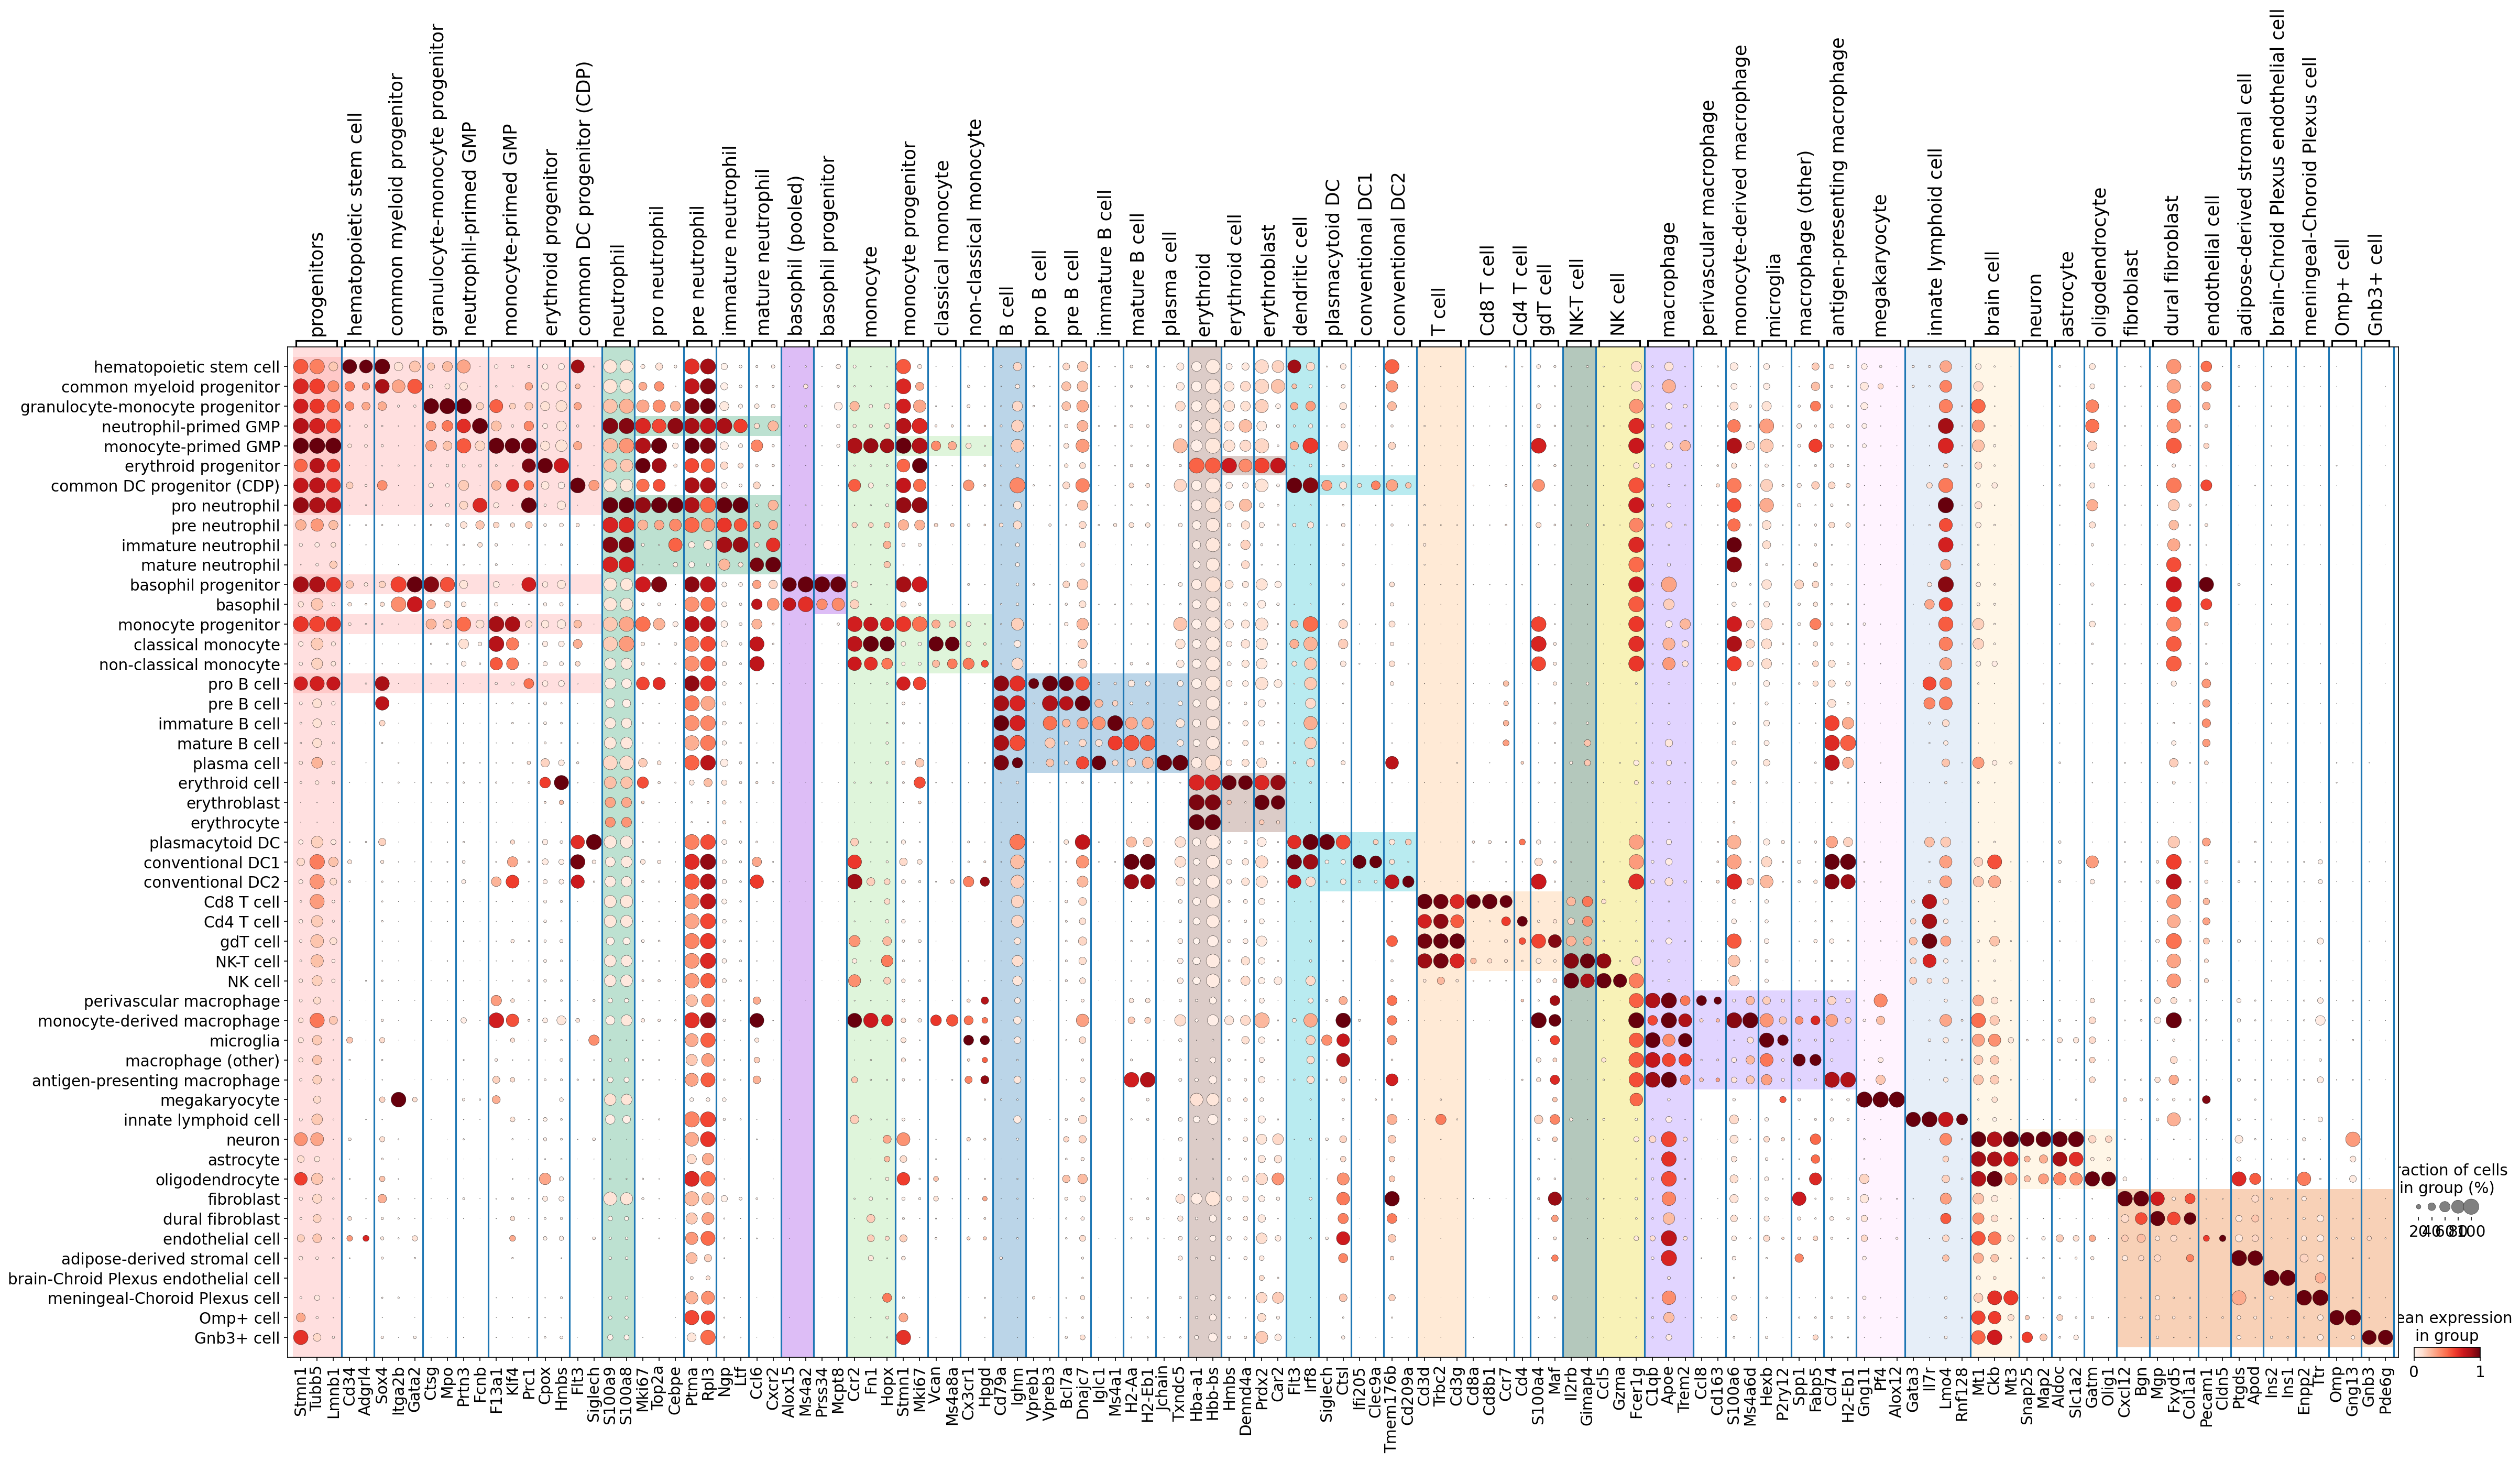

In [35]:
import matplotlib.patches as patches

plt.figure(figsize=(36,18))
dp = sc.pl.dotplot(adata,genes,"level2",standard_scale="var",show=False,ax=plt.gca())#,save="marker_all_celltypes.pdf")

n_rows = len(adata.obs["level2"].cat.categories)
gene_count = 0
rects2 = {key:{"start":None, "width":None} for key in sub_states_boxes}
latest_colored_ct = list(sub_states_boxes.keys())[0]
for i, ct in enumerate(genes):
    n_genes = len(genes[ct])
    if (ct in adata.obs["level1"].cat.categories):
        color = adata.uns["level1_colors"][adata.obs["level1"].cat.categories.tolist().index(ct)]
        rect = patches.Rectangle(
            (gene_count+0.0, -0.5), n_genes-0.0, 
            n_rows+1, linewidth=1, edgecolor='none', facecolor=color, alpha=0.3, #facecolor='lightgrey', 
            zorder=0
        )
        if ct in sub_states_boxes.keys():
            dp["mainplot_ax"].add_patch(rect)
        
    if rects2[latest_colored_ct]["start"] is None:
        rects2[latest_colored_ct]["start"] = gene_count
    rects2[latest_colored_ct]["width"] = gene_count - rects2[latest_colored_ct]["start"]
    gene_count += n_genes
    
    
    if ct in sub_states_boxes:
        latest_colored_ct = ct
    else: # little trick since we don't show structural cell... too tired to generalise atm
        if ct not in sub_states_boxes[latest_colored_ct]:
            latest_colored_ct = "structural cell"
            rects2[latest_colored_ct]["start"] = gene_count - n_genes

if ct in adata.obs["level2"].cat.categories:
    rects2[latest_colored_ct]["width"] = gene_count - rects2[latest_colored_ct]["start"]


for ct, ct2s in sub_states_boxes.items():
    color = adata.uns["level1_colors"][adata.obs["level1"].cat.categories.tolist().index(ct)]
    for ct2 in ct2s:
        row = adata.obs["level2"].cat.categories.tolist().index(ct2)
        try:
            rect = patches.Rectangle(
                (rects2[ct]["start"]+0.0, row - 0.0), rects2[ct]["width"]-0.0, 
                1, linewidth=1, edgecolor='none', facecolor=color, alpha=0.3, #facecolor='lightgrey', 
                zorder=0
            )
        except:
            print(ct, ct2)
        dp["mainplot_ax"].add_patch(rect)        
        
count = 0
for _,gs in genes.items():
    count += len(gs)
    dp["mainplot_ax"].axvline(x=count)

plt.gcf().savefig("./figures/dotplot_celltype_annotation.pdf", bbox_inches = "tight")
    
plt.show()

#### Extra plot for legend

In [10]:
genes = {
    'progenitors': ['Stmn1', 'Tubb5', 'Lmnb1'],
    'hematopoietic stem cell': ['Cd34', 'Adgrl4'],
    'common myeloid progenitor': ['Sox4', 'Itga2b', 'Gata2'],
    'granulocyte-monocyte progenitor': ['Ctsg', 'Mpo'],
    'neutrophil-primed GMP': ['Prtn3', 'Fcnb'],
    'monocyte-primed GMP': ['F13a1', 'Klf4', 'Prc1'],
    'erythroid progenitor': ['Cpox', 'Hmbs'],
    'common DC progenitor (CDP)': ['Flt3', 'Siglech'],
}

{'progenitors': ['Stmn1', 'Tubb5', 'Lmnb1'],
 'hematopoietic stem cell': ['Cd34', 'Adgrl4'],
 'common myeloid progenitor': ['Sox4', 'Itga2b', 'Gata2'],
 'granulocyte-monocyte progenitor': ['Ctsg', 'Mpo'],
 'neutrophil-primed GMP': ['Prtn3', 'Fcnb'],
 'monocyte-primed GMP': ['F13a1', 'Klf4', 'Prc1'],
 'erythroid progenitor': ['Cpox', 'Hmbs'],
 'common DC progenitor (CDP)': ['Flt3', 'Siglech'],
 'neutrophil': ['S100a9', 'S100a8'],
 'pro neutrophil': ['Mki67', 'Top2a', 'Cebpe'],
 'pre neutrophil': ['Ptma', 'Rpl3'],
 'immature neutrophil': ['Ngp', 'Ltf'],
 'mature neutrophil': ['Ccl6', 'Cxcr2'],
 'basophil (pooled)': ['Alox15', 'Ms4a2'],
 'basophil progenitor': ['Prss34', 'Mcpt8'],
 'monocyte': ['Ccr2', 'Fn1', 'Hopx'],
 'monocyte progenitor': ['Stmn1', 'Mki67'],
 'classical monocyte': ['Vcan', 'Ms4a8a'],
 'non-classical monocyte': ['Cx3cr1', 'Hpgd'],
 'B cell': ['Cd79a', 'Ighm'],
 'pro B cell': ['Vpreb1', 'Vpreb3'],
 'pre B cell': ['Bcl7a', 'Dnajc7'],
 'immature B cell': ['Iglc1', 'Ms4a1']

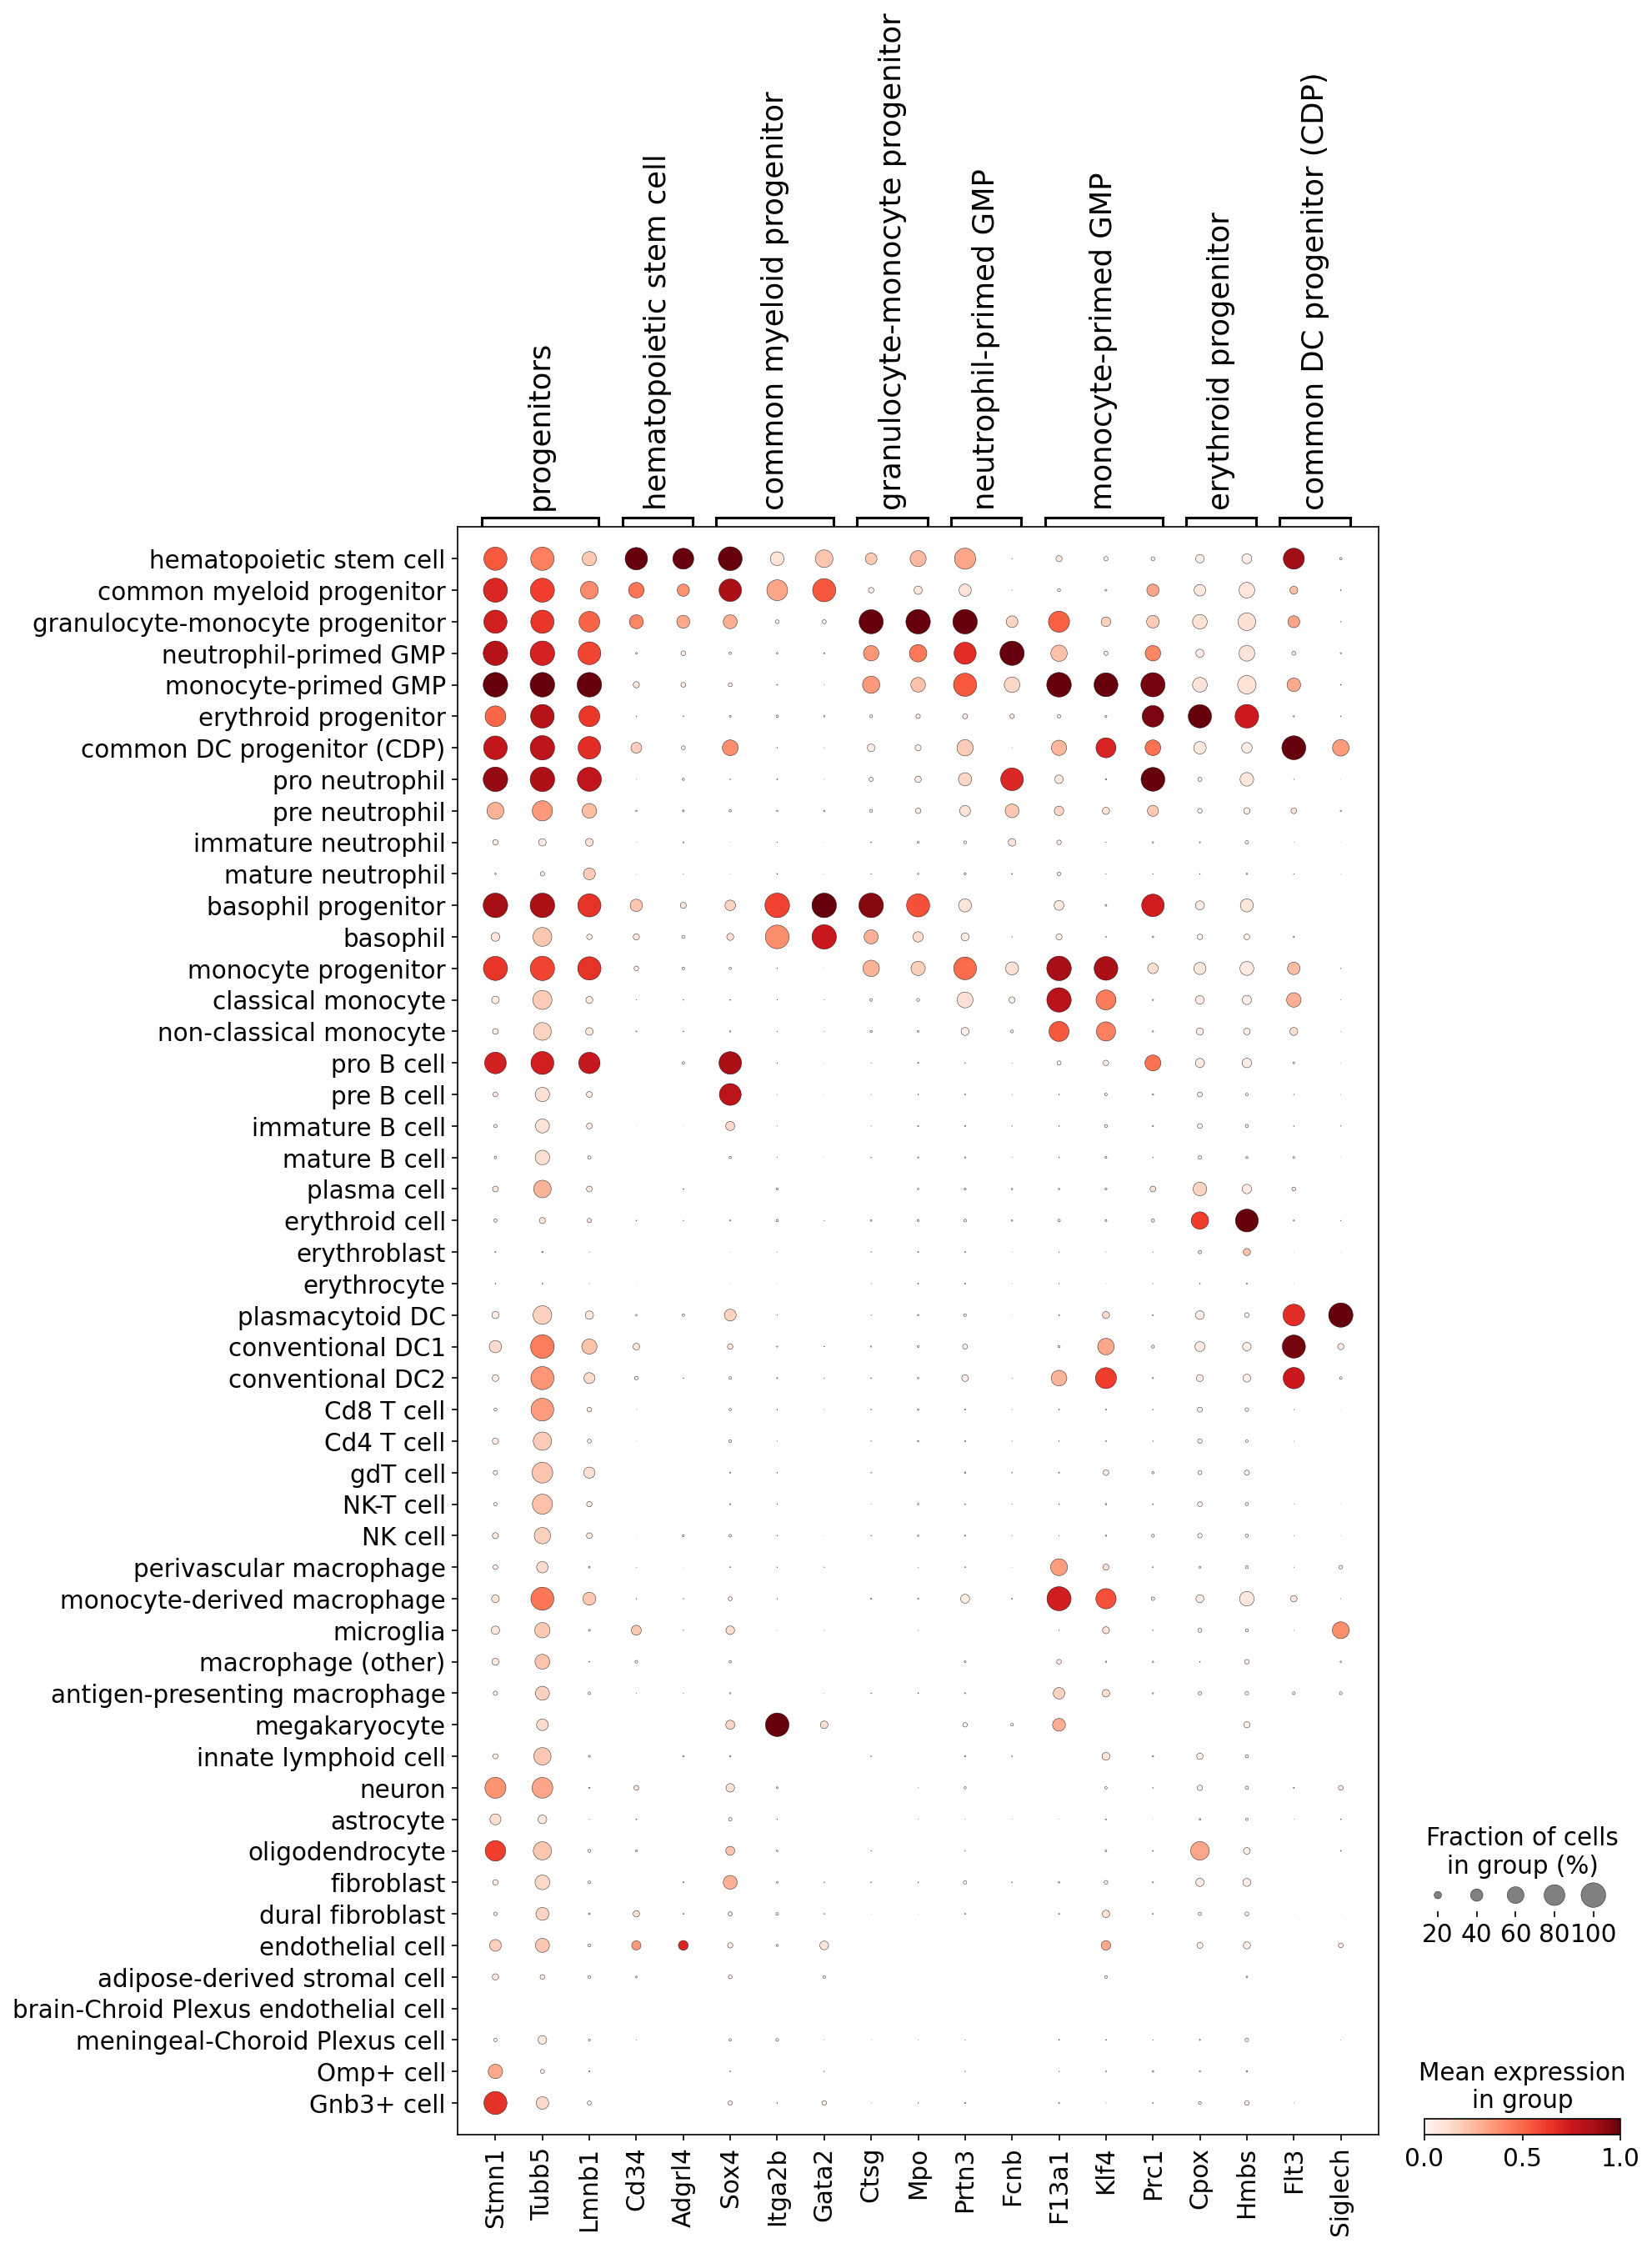

In [13]:
import matplotlib.patches as patches

genes = {
    'progenitors': ['Stmn1', 'Tubb5', 'Lmnb1'],
    'hematopoietic stem cell': ['Cd34', 'Adgrl4'],
    'common myeloid progenitor': ['Sox4', 'Itga2b', 'Gata2'],
    'granulocyte-monocyte progenitor': ['Ctsg', 'Mpo'],
    'neutrophil-primed GMP': ['Prtn3', 'Fcnb'],
    'monocyte-primed GMP': ['F13a1', 'Klf4', 'Prc1'],
    'erythroid progenitor': ['Cpox', 'Hmbs'],
    'common DC progenitor (CDP)': ['Flt3', 'Siglech'],
}

plt.figure(figsize=(12,18))
dp = sc.pl.dotplot(adata,genes,"level2",standard_scale="var",show=False,ax=plt.gca())#,save="marker_all_celltypes.pdf")


plt.gcf().savefig("./figures/dotplot_celltype_annotation_legend.pdf", bbox_inches = "tight")
    
plt.show()